# What is this notebook?

The point of this notebook is to try the same "model" with diffent manipulations of the data, so see which resampling method or dataset gives the best results. The goal of the project is to predict schools that are closed, but there are many more operating schools than closed schools, so the dataset it unbalanced with respect to the target variable.

Different resampling techniques are used to try to balance the database, and the best method will be chosen based on the resulting accuracy and recall & precision of the minority (negative) class. Each dataset will first be run through a Decision Tree model, which will then form the basis for an AdaBoost model.

In [1]:
# Set up the environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [3]:
# Upload the original dataset - Subsets will be made off of this original dataframe
original = pd.read_csv('../data/processed/DecisionTreeDataFinal.csv', index_col=0)
to_drop = ['CITY', 'HIGHDEG', 'ADM_RATE', 'NetPrice', 'region','EnrollmentBins','Complete',\
           'TuitionBins','ExpenditureBins', 'AVGFACSAL', 'RetentionPT', 'PCTFLOAN']
original = original.drop(to_drop, axis=1)
original.head()

,OPEID,INSTNM,NUMBRANCH,PREDDEG,CONTROL,UGDS,CURROPER,TUITFTE,INEXPFTE,PFTFAC,UG25abv,COMP_ORIG_YR4_RT,WDRAW_ORIG_YR4_RT,ENRL_ORIG_YR4_RT,DEBT_MDN,Year,Cost,PREDDEG_N,Governance,RetentionFT
897,00104706,troy university-atlantic region,8,0,1,986.0,False,2090.5,4392.5,0.2481,0.4245,0.171947,0.346515,0.128031,14750.0,2010,19036.5,Not classified,Public,0.52400
898,00104720,troy university-western region,8,0,1,986.0,False,2090.5,4392.5,0.2481,0.4245,0.171947,0.346515,0.128031,14750.0,2010,19036.5,Not classified,Public,0.52400
1693,00104720,troy university-western region,7,0,1,986.0,False,2090.5,4392.5,0.2481,0.4245,0.211538,0.324624,0.126254,15829.0,2011,19036.5,Not classified,Public,0.52400
899,001047A1,troy university-ecampus,8,0,1,986.0,False,2090.5,4392.5,0.2481,0.4245,0.171947,0.346515,0.128031,14750.0,2010,19036.5,Not classified,Public,0.52400
3,00107000,thunderbird school of global management,1,1,2,2.0,False,49859.0,33004.0,0.6301,0.5258,0.604934,0.000000,0.000000,9500.0,2010,19623.0,Certificate,Private nonprofit,0.74085


In [4]:
original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10200 entries, 897 to 5365
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   OPEID              10200 non-null  object 
 1   INSTNM             10200 non-null  object 
 2   NUMBRANCH          10200 non-null  int64  
 3   PREDDEG            10200 non-null  int64  
 4   CONTROL            10200 non-null  int64  
 5   UGDS               10200 non-null  float64
 6   CURROPER           10200 non-null  bool   
 7   TUITFTE            10200 non-null  float64
 8   INEXPFTE           10200 non-null  float64
 9   PFTFAC             10200 non-null  float64
 10  UG25abv            10200 non-null  float64
 11  COMP_ORIG_YR4_RT   10200 non-null  float64
 12  WDRAW_ORIG_YR4_RT  10200 non-null  float64
 13  ENRL_ORIG_YR4_RT   10200 non-null  float64
 14  DEBT_MDN           10200 non-null  float64
 15  Year               10200 non-null  int64  
 16  Cost               10

In [5]:
original_closed = original.loc[original.CURROPER == False]
original_closed.shape

(2759, 20)

In [6]:
original_open = original.loc[original.CURROPER==True]
original_open.shape

(7441, 20)

In [7]:
current_open = original_open.loc[original_open.Year > 2012]
current_open.shape

(7441, 20)

In [8]:
current = current_open.append(original_closed)
print("Shape:" , current.shape)
current.CURROPER.value_counts()

Shape: (10200, 20)


True     7441
False    2759
Name: CURROPER, dtype: int64

## Create the new datasets

In [9]:
# Original dataset, but resample the closed data by simply adding all it again
double_closed = current.append(original_closed)
print("Shape: ", double_closed.shape)
double_closed.CURROPER.value_counts()

Shape:  (12959, 20)


True     7441
False    5518
Name: CURROPER, dtype: int64

In [10]:
# Original dataset, but resample the closed data to be double in number
double_upsample = resample(original_closed, replace=True, n_samples=original_closed.shape[0]*2, random_state=123)
resample_double = pd.concat([current_open, double_upsample], axis=0)
print("Shape: ", resample_double.shape)
resample_double.CURROPER.value_counts()

Shape:  (12959, 20)


True     7441
False    5518
Name: CURROPER, dtype: int64

In [11]:
# Original dataset, but resample the closed data to make it the same size as the open class
closed_upsample = resample(original_closed, replace=True, n_samples=current_open.shape[0], random_state=123)
resample_closed = pd.concat([current_open, closed_upsample], axis=0)
print("Shape: ", resample_closed.shape)
resample_closed.CURROPER.value_counts()

Shape:  (14882, 20)


True     7441
False    7441
Name: CURROPER, dtype: int64

In [12]:
# Original dataset, but resample the closed data to make it half the size as the open class
full_open = current_open.shape[0]
half_open = int(full_open / 2)

closed_halfsample = resample(original_closed, replace=True, n_samples=half_open, random_state=123)
resample_half = pd.concat([current_open, closed_halfsample], axis=0)
print("Shape: ", resample_closed.shape)
resample_half.CURROPER.value_counts()

Shape:  (14882, 20)


True     7441
False    3720
Name: CURROPER, dtype: int64

In [13]:
# All closed bachelors schools from original, but only the last year for open bachelors schools
all_bach = original.loc[original.PREDDEG==3]
closed_bach = all_bach.loc[all_bach.CURROPER == False]
print("Closed bachelors shape: ", closed_bach.shape)
open_bach = all_bach.loc[all_bach.CURROPER == True]
current_bach = open_bach.loc[all_bach.Year > 2012]
print("Current open bachelors shape: ", current_bach.shape)
bachelor = pd.concat([closed_bach, current_bach], axis=0)
print("Shape: ", bachelor.shape)

Closed bachelors shape:  (241, 20)
Current open bachelors shape:  (2101, 20)
Shape:  (2342, 20)


In [14]:
# Resample the closed bachelor schools to be roughly equal to the number of open bachelors schools
bachelor_upsample = resample(closed_bach, replace=True, n_samples = current_bach.shape[0], random_state=123)
bachelor_resample = pd.concat([bachelor_upsample, current_bach], axis=0)
print("Shape: ", bachelor_resample.shape)
bachelor_resample.CURROPER.value_counts()

Shape:  (4202, 20)


True     2101
False    2101
Name: CURROPER, dtype: int64

In [15]:
current_dict = {'data':current}
double_closed_dict = {'data':double_closed}
resample_double = {'data':resample_double}
resample_closed_dict = {'data':resample_closed}
resample_half_dict = {'data':resample_half}
bachelor_dict = {'data':bachelor}
bachelor_resample_dict = {'data':bachelor_resample}

datasets = {'current':current_dict, 'double_closed':double_closed_dict, 'resample_double':resample_double,
            'resample_half':resample_half_dict, 'resample_closed':resample_closed_dict,
            'bachelor':bachelor_dict, 'bachelor_resample':bachelor_resample_dict}

## Create a pipeline/for loop to process all of the datasets.
First define functions to do the different modeling tasks that I want.

In [16]:
def tree_depth(X_train, X_test, y_train, y_test):
    max_depth = []
    acc_gini = []
    acc_entropy = []
    for i in range(1, 31):
        gtree = DecisionTreeClassifier(criterion='gini', max_depth=i, random_state=21)
        gtree.fit(X_train, y_train)
        gpredict = gtree.predict(X_test)
        acc_gini.append(metrics.accuracy_score(y_test, gpredict))
        ##
        etree = DecisionTreeClassifier(criterion='entropy', max_depth=i, random_state=21)
        etree.fit(X_train, y_train)
        epredict = etree.predict(X_test)
        acc_entropy.append(metrics.accuracy_score(y_test, epredict))
        ##
        max_depth.append(i)
        
    gini_max = max(acc_gini)
    gini_idx = acc_gini.index(gini_max)
    entropy_max = max(acc_entropy)
    entropy_idx = acc_entropy.index(entropy_max)

    if gini_max > entropy_max:
        depth = max_depth[gini_idx]
        crit = 'gini'
    else:
        depth = max_depth[entropy_idx]
        crit='entropy'
    
    return depth, crit
        

In [17]:
def AB_n_estimators(X_train, X_test, y_train, y_test, model):
    AB_depth = []
    score_b = []

    for i in range(105, 131, 1):
        btree = AdaBoostClassifier(model, n_estimators=i, random_state=21)
        btree.fit(X_train, y_train)
        bpredict = btree.predict(X_test)
        score_b.append(metrics.accuracy_score(y_test, bpredict))
        AB_depth.append(i)
        
    ideal_estimators = max(score_b)
    idx = score_b.index(ideal_estimators)
    return AB_depth[idx]

In [18]:
for dset in datasets:
    # Split into X and y
    data = datasets[dset]['data']
    y = data['CURROPER']
    X = data.drop(['CURROPER', 'OPEID', 'INSTNM', 'Year', 'Governance', 'PREDDEG_N'], axis=1)
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=21, stratify=y)
    # Cycle through Decision Tree model to get best depth
    DTdepth, DTcrit = tree_depth(X_train, X_test, y_train, y_test)
    # Train Decision Tree model with best depth
    modelDT = DecisionTreeClassifier(criterion=DTcrit, max_depth=DTdepth, random_state=21)
    datasets[dset]['dt_model'] = modelDT.fit(X_train, y_train)
    datasets[dset]['dt_pred'] = modelDT.predict(X_test)
    datasets[dset]['dt_pred_prob'] = modelDT.predict_proba(X_test)
    datasets[dset]['y_test'] = y_test
    # Record metrics
    datasets[dset]['dt_confusion'] = metrics.confusion_matrix(y_test, datasets[dset]['dt_pred'])
    datasets[dset]['dt_classification'] = metrics.classification_report(y_test, datasets[dset]['dt_pred'])
    
    # Cycle through AdaBoost model to get n_estimators
    n_est = AB_n_estimators(X_train, X_test, y_train, y_test, modelDT)
    # Train AdaBoost model with n_estimators
    modelAB = AdaBoostClassifier(modelDT, n_estimators=n_est, random_state=21)
    datasets[dset]['ab_model'] = modelAB.fit(X_train, y_train)
    datasets[dset]['ab_pred'] = modelAB.predict(X_test)
    datasets[dset]['ab_pred_prob'] = modelAB.predict_proba(X_test)
    
    # Record metrics
    datasets[dset]['ab_confusion'] = metrics.confusion_matrix(y_test, datasets[dset]['ab_pred'])
    datasets[dset]['ab_classification'] = metrics.classification_report(y_test, datasets[dset]['ab_pred'])

In [19]:
AB_accuracy = []
AB_no_prec = []
AB_no_recall = []
for dset in datasets:
    acc = metrics.accuracy_score(datasets[dset]['y_test'], datasets[dset]['ab_pred'])
    prec = metrics.precision_score(datasets[dset]['y_test'], datasets[dset]['ab_pred'], pos_label = 0)
    rec = metrics.recall_score(datasets[dset]['y_test'], datasets[dset]['ab_pred'], pos_label = 0)
    AB_accuracy.append(acc)
    AB_no_prec.append(prec)
    AB_no_recall.append(rec)

In [20]:
models = [key for key in datasets.keys()]
names=['Current', 'Double','Dbl-Resamp','Half', 'Resample', 'Bachelor', 'B_resamp']

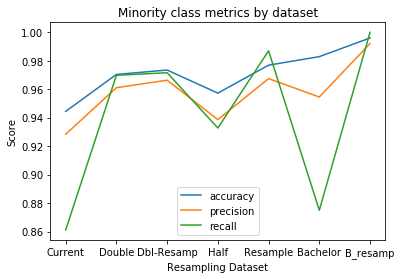

In [21]:
plt.plot(names, AB_accuracy, label='accuracy')
plt.plot(names, AB_no_prec, label='precision')
plt.plot(names, AB_no_recall, label = 'recall')
plt.ylabel('Score')
plt.xlabel('Resampling Dataset')
plt.title('Minority class metrics by dataset')
plt.legend()
#plt.show()
plt.savefig('../figures/ResampleMethods.png')

### Compare accuracy for double-resample model and resample model

In [22]:
print(AB_accuracy[2:5])#, max(AB_no_prec), max(AB_no_recall))

[0.9735082304526749, 0.9573006867721708, 0.9769316909294513]


In [23]:
print(AB_no_prec[2:5])

[0.9663663663663664, 0.9386834986474302, 0.9675010979358806]


In [24]:
print(AB_no_recall[2:5])

[0.9716183574879227, 0.9327956989247311, 0.9870071684587813]


Based on the accuracy, recall and precision for the negative class (the target variable), the 'double-resample' dataset and 'resample' datasets seems to give the best results for the total database (as opposed to just the bachelor's degree granting institutions).

The 'double-resample' dataset doubles the number of observations of the minority class via resampling, for a total of 5518 minority class observations.

The 'resample' dataset balances the number of observations in each class by resampling the minory class up to the size as the majority class. While this dataset has slightly better metrics in this run of the model, it performed slightly worse in previous runs of the model (before the random_state was seeded). It also manipulates/resamples the data more than the 'double-resample' dataset for a slight gain, mostly in the negative recall.

The 'double-resample' method will be used for in the final modeling.